<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/blood_transfusion/autokeras_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q git+https://github.com/keras-team/keras-tuner.git@1.0.2rc3
%pip install -q autokeras
%pip show keras-tuner autokeras scikit-learn

     |████████████████████████████████| 143kB 9.9MB/s 
     |████████████████████████████████| 849kB 22.6MB/s 
     |████████████████████████████████| 36.7MB 82kB/s 
     |████████████████████████████████| 174kB 57.2MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 358kB 45.6MB/s 
     |████████████████████████████████| 1.1MB 51.5MB/s 
Name: keras-tuner
Version: 1.0.2rc3
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: colorama, scikit-learn, terminaltables, future, tabulate, packaging, tqdm, scipy, numpy, requests
Required-by: 
---
Name: autokeras
Version: 1.0.10
Summary: AutoML for deep learning
Home-page: http://autokeras.com
Author: Data Analytics at Texas A&M (DATA) Lab, Keras Team
Author-email: jhfjhfj1@gmail.com
License: MIT
Location: /usr/lo

[輸血データセット:https://www.openml.org/d/1464](https://www.openml.org/d/1464)

In [2]:
import datetime, IPython, os 

import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from autokeras import StructuredDataClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# データ読み込み

In [3]:
%%time
DATA_ID = '1464' #@param{type:'string'}

# データセットをフェッチ
X, y = fetch_openml(data_id=DATA_ID, return_X_y=True, as_frame=True)
display(X)


def processing_y(y):
    '''ラベルyの加工'''
    def _convert_dtype(y, type='int64'):
        '''dtype: category(文字列型)をint64に変更'''
        return y.astype('int64')
    
    def _indicator_start_0(y):
        '''インディケータ開始の数を0にする'''
        return y - y[np.argmin(y)]

    y = _convert_dtype(y)
    y = _indicator_start_0(y)
    return y


y = processing_y(y)
display(y)


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))

,V1,V2,V3,V4
0,2.0,50.0,12500.0,98.0
1,0.0,13.0,3250.0,28.0
2,1.0,16.0,4000.0,35.0
3,2.0,20.0,5000.0,45.0
4,1.0,24.0,6000.0,77.0
...,...,...,...,...
743,23.0,2.0,500.0,38.0
744,21.0,2.0,500.0,52.0
745,23.0,3.0,750.0,62.0
746,39.0,1.0,250.0,39.0


0      1
1      1
2      1
3      1
4      0
      ..
743    0
744    0
745    0
746    0
747    0
Name: Class, Length: 748, dtype: int64

'train shape:(478, 4)'

'val shape:(120, 4)'

'test shape:(150, 4)'

CPU times: user 57.8 ms, sys: 7.79 ms, total: 65.6 ms
Wall time: 1.3 s


# モデル構築

In [34]:
# 探索アルゴリズムの試行回数
MAX_TRIALS =  5#@param{type:'number'}

clf = StructuredDataClassifier(overwrite=True,
                               max_trials=MAX_TRIALS,
                               seed=SEED)
display(clf)


# 各モデルのepoch数
EPOCH =  30#@param{type:'number'}

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=5)

In [35]:
%%time
clf.fit(x=train_X, y=train_y, epochs=EPOCH,
        validation_data=(val_X, val_y),
        callbacks=[es])

Trial 5 Complete [00h 00m 02s]
val_accuracy: 0.7916666865348816

Best val_accuracy So Far: 0.8083333373069763
Total elapsed time: 00h 00m 10s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
CPU times: user 12.3 s, sys: 743 ms, total: 13 s
Wall time: 11.9 s


# ベストなモデルの可視化

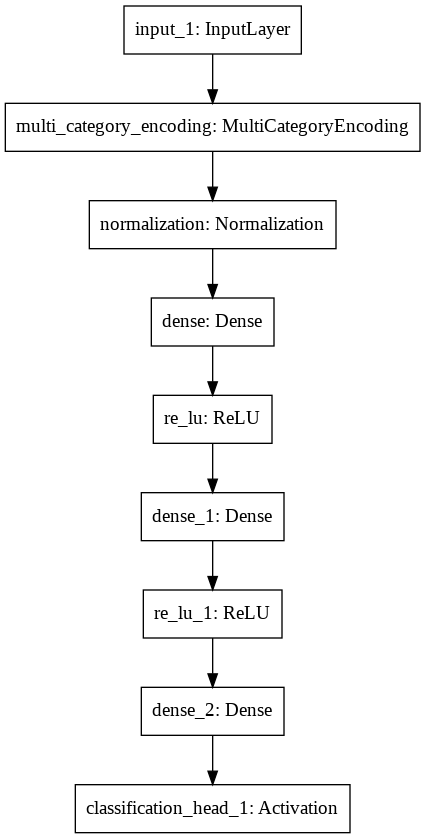

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 4)                 0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

None

In [26]:
def display_best_model(ak_model):
    '''ベストなモデルの構造を表示'''
    best_model = ak_model.export_model()
    display(plot_model(best_model))
    display(best_model.summary())


display_best_model(ak_model=clf)

# モデルの評価

In [36]:
def take_best_model(ak_model):
    '''ベストなモデルを取り出し'''
    best_model = ak_model.export_model()
    return best_model


model = take_best_model(ak_model=clf)

## Kerasの組み込み評価関数

In [37]:
score = model.evaluate(x=test_X, y=test_y, batch_size=256)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

1/1 [==============================] - 0s 1ms/step - loss: 0.5000 - accuracy: 0.7867


'loss : 0.49995550513267517, accuracy : 0.7866666913032532'

## sklearnの評価関数

In [41]:
%%time
def predict_classes(model, X):
    '''ラスラベルの予測を取得
    INFO : 二項分類モデル用'''
    return np.where(model.predict(X)<0.5, 0, 1)


# 予測結果の取得
train_y_pred = predict_classes(model, train_X.values)
val_y_pred = predict_classes(model, val_X.values)
test_y_pred = predict_classes(model, test_X.values)


train_report = classification_report(y_true=train_y, y_pred=train_y_pred)
val_report = classification_report(y_true=val_y, y_pred=val_y_pred)
test_report = classification_report(y_true=test_y, y_pred=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       366
           1       0.63      0.32      0.43       112

    accuracy                           0.80       478
   macro avg       0.73      0.63      0.65       478
weighted avg       0.78      0.80      0.77       478

----- -----
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        92
           1       0.73      0.29      0.41        28

    accuracy                           0.81       120
   macro avg       0.77      0.63      0.65       120
weighted avg       0.80      0.81      0.77       120

----- -----
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       112
           1       0.71      0.26      0.38        38

    accuracy                           0.79       150
   macro avg       0.75      0.61      0.63       150
weighted avg       0.77      0.79      0.75       